# Example of visualising the data 
## For reproducing the results in the paper

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os 
import warnings
warnings.filterwarnings('ignore')


from matplotlib import cm
from joypy import joyplot
from utils.data_utils import correct_col_type,gen_date_col,transform_category_to_counts,gen_summary
from utils.vis_utils import vis_day_counts_ridge_plot,save_fig,vis_personal_aligned_multiview_day_plot

In [2]:
%matplotlib inline

In [3]:
## Please change the path with the path of your dataset
DPATH = '../Dataset/'
SAVE_PATH = './figs/'

In [4]:
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [5]:
## Read all tables into data_dict and generate table summaries

files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)
    
    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})
                
    fname = f.split('.')[0]
    data_dict[fname] = df
    
    summaries[fname] = gen_summary(df)

Labels.csv
Physiology.csv
Activity.csv
Sleep.csv
Demographics.csv


In [6]:
summaries['Sleep']

,Value Type,Value Number,Description
patient_id,CategoricalDtype,17,hash code
timestamp,dtype[datetime64],NaN,from 2019-04-01 00:00:00 to 2019-06-30 23:59:00
state,CategoricalDtype,4,"REM,DEEP,AWAKE,LIGHT,"
heart_rate,dtype[float64],NaN,"min: 38.0, max: 107.0"
respiratory_rate,dtype[float64],NaN,"min: 8.0, max: 31.0"
snoring,dtype[bool_],2,True or False


In [7]:
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

In [8]:
## Generate a date column for Labels table 
lbl_df = gen_date_col(data_dict['Labels'],tcol='timestamp')
lbl_df.type.value_counts()

Blood pressure      305
Agitation           135
Pulse                95
Body water           68
Weight                4
Body temperature      1
Name: type, dtype: int64

In [9]:
## Generate a date column for Labels table
lbl_daily_df = transform_category_to_counts(lbl_df,col='type',keys=['patient_id','date'])
lbl_daily_df.to_csv(os.path.join(DPATH,"Labels_daily.csv"),index=False)
lbl_daily_df.head()

type,patient_id,date,Agitation,Blood pressure,Body temperature,Body water,Pulse,Weight
0,0697d,2019-06-28,0,1,0,0,1,0
1,0697d,2019-06-29,0,1,0,0,0,0
2,0697d,2019-06-30,0,0,0,0,1,0
3,099bc,2019-05-20,0,1,0,0,0,0
4,099bc,2019-06-01,0,1,0,0,0,0


In [10]:
## Generate a date column for Activity table 
act_df1 = gen_date_col(data_dict['Activity'],tcol='timestamp')
act_df1.location_name.value_counts()

Kitchen        227312
Hallway        193984
Lounge         180767
Bedroom        131133
Fridge Door    108803
Bathroom        82027
Front Door      58287
Back Door       48246
Name: location_name, dtype: int64

In [11]:
## Aggreate daily counts of acitivities in each location
act_df = transform_category_to_counts(act_df1,col='location_name',keys=['patient_id','date'])
act_df.head()

location_name,patient_id,date,Back Door,Bathroom,Bedroom,Fridge Door,Front Door,Hallway,Kitchen,Lounge
0,0697d,2019-06-28,14,7,24,23,28,40,106,80
1,0697d,2019-06-29,2,11,26,8,23,57,120,117
2,0697d,2019-06-30,4,14,53,0,8,57,119,103
3,099bc,2019-05-15,12,17,31,27,13,32,71,6
4,099bc,2019-05-16,14,42,85,22,6,50,104,9


In [12]:
## Calculate average person-day in the dataset
p_ct = act_df.groupby('date').size().to_frame('Number of Patients')
act_df.groupby('patient_id').size().mean()

48.607142857142854

Text(0, 0.5, 'Number of Paticipants')

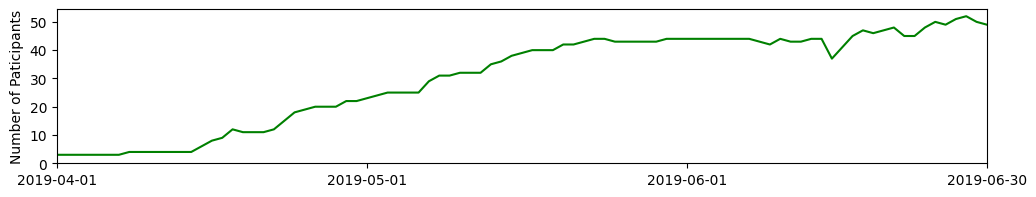

In [13]:
## Visualise number of paticipants with time
plt.figure(figsize=[12,2])
plt.plot(p_ct,color='g')
idx = [0,29,60,88]
plt.xticks(p_ct.index[idx],labels=p_ct.index[idx])

plt.xlim(p_ct.index[0],p_ct.index[-1])
plt.yticks(np.arange(0,60,10))
plt.ylabel('Number of Paticipants')

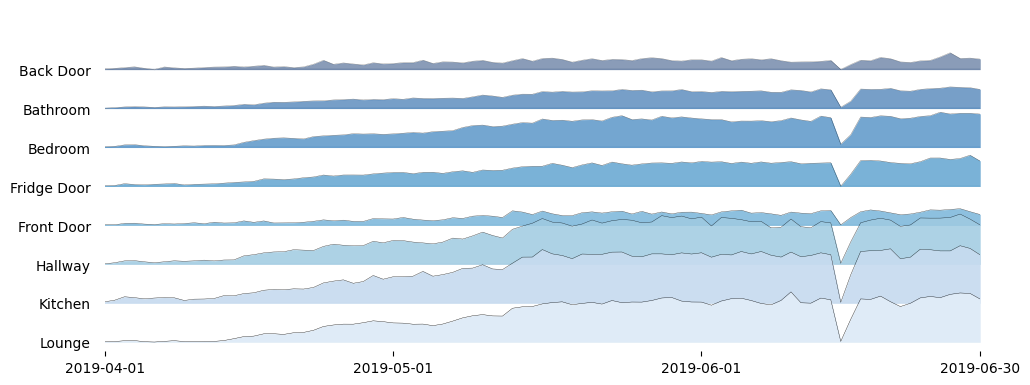

In [14]:
## Visualise location-activity with time

all_act = act_df.groupby('date').agg('sum')
vis_day_counts_ridge_plot(act_df,'location_name',title='',
                          fname='all_activity_ridgeplot.svg',save_path=SAVE_PATH,
                          xticks=([0,29,60,88],all_act.index[[0,29,60,-1]]))

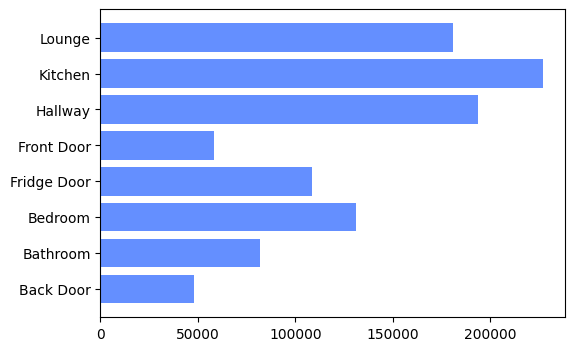

In [15]:
## Visualise total counts of each location
tmp = act_df.groupby('date').sum()
plt.figure(figsize=[6,4])
bars = plt.barh(width=tmp.sum(axis=0),y=tmp.columns)

In [16]:
tmp.sum(axis=0)

location_name
Back Door       48246
Bathroom        82027
Bedroom        131133
Fridge Door    108803
Front Door      58287
Hallway        193984
Kitchen        227312
Lounge         180767
dtype: int64

In [17]:
## Aggregate Physiology table
physio_df = gen_date_col(data_dict['Physiology'],tcol='timestamp')
phys = physio_df.groupby(['patient_id','date','device_type']).agg('max')
phys.drop(phys.loc[phys.sum(axis=1)==0].index,axis=0,inplace=True)
phys.reset_index(inplace=True)
phys.head()

,patient_id,date,device_type,timestamp,value
0,0697d,2019-06-28,Body Temperature,2019-06-28 14:25:37,36.599
1,0697d,2019-06-28,Body weight,2019-06-28 14:40:13,86.300
2,0697d,2019-06-28,Diastolic blood pressure,2019-06-28 13:45:15,82.000
3,0697d,2019-06-28,Heart rate,2019-06-28 13:45:15,42.000
4,0697d,2019-06-28,O/E - muscle mass,2019-06-28 14:40:13,64.500


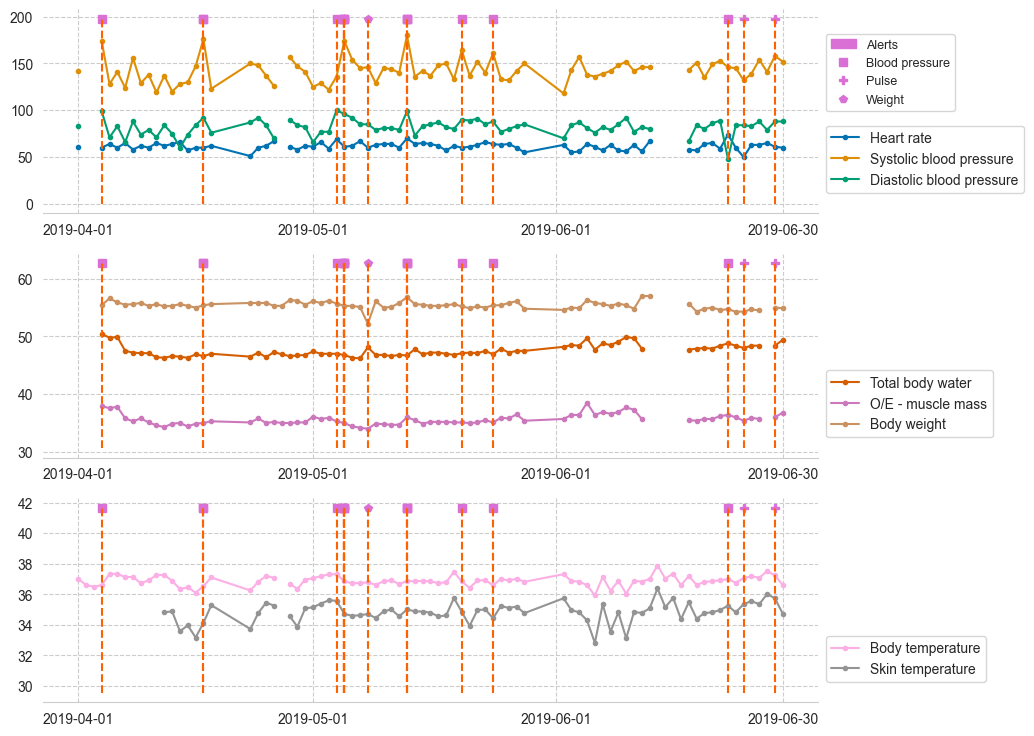

In [18]:
## Visualize Physiology measurements align with labels for an individual participant
pgrps = {'pgrp1': ['Systolic blood pressure','Diastolic blood pressure', 'Heart rate'], 
            'pgrp2' : ['O/E - muscle mass', 'Total body water', 'Body weight'],
            'pgrp3' : [ 'Skin temperature','Body temperature']}
x_idx = phys.groupby('date').mean().index

vis_personal_aligned_multiview_day_plot(sleep_df=None,act_df=None,phys_df=phys,pgrps=pgrps,pid='c55f8',save_path=SAVE_PATH,
                                        labels_df=lbl_df,ftype='pdf',xticks=(x_idx[[0,30,61,90]],x_idx[[0,30,61,90]]))